We want to find causal effect of a treatment or an intervention on an outcome of business interest. 
$$Y(1)-Y(0)$$
Fundamental Problem of Causal Inference: We only observe either with or without treatment. Not both. 



Broadly there are two lines of research in Causal ML

1. Modifying Machine Learning methods to estimate unbiased and consistent average treatment effect. 
        a.How will customers react on average to a marketing campaign? 
        b.What is the average effect of a price change on sales? 
2. Modifying Machine Learning methods to uncover treatment effect heterogeneity.
        a.Which customers respond the most to a marketing campaign? 
        b.How does the effect of a price change on sales change with the age of customers?
1 and 2 both can be usually solved with randomized control trials (RCT) and A/B testing. You need other solutions when RCT and A/B testings are not practical (sometimes it's a problem with resources or other times it is not possible to do a RCT due to ethical reasons, e.g. smoking). 

There exists multiple other methods to do causal inference from just using observational data. 

Why do we need to go beyond traditional Machine Learning techniques to find causal effects?

- ML models are focused on correlation not causation.
- Decision-making depends on understanding the effects of decisions and actions. 

Some examples:
    1. A classic ML model will predict given the price, what is the occupancy rate in airplanes. Higher prices usually correlates with higher occupancy. But it is wrong to assume that if we raise prices the occupancy will be higher. Cause and effect happen the other way around. Ticket prices increases as the occupancy rate increases. 
    2. ML model is trained to predict the water quantity of the soil on a farm land by taking the temperature as input. The moisture level of the soil is usually high in warmer days due to farmers interventions. If we use this model and rely on it to predict when should we water the farm land it would predict colder days, which is wrong.

### Customer Churn

Classical ML algorithms are very good at predicting customer churn. But can it address companies resource allocation problem of which customer to best target with intervention strategies? 

- Which customers best respond to additional Customer support/Cash incentives and stop from churning?

- It can also help us to understand why a customer is churning from techniques like Shap values. 
(Shap values from a causal model can be different from the shape values from a traditional ML model)




In [1]:
import dowhy
from dowhy import CausalModel
import dowhy.datasets

In [2]:
# load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True,
    stddev_treatment_noise=10)

In [3]:
data['ate']

In [6]:
data['df'].head()

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.319352,-1.150618,1.438988,-0.834182,2.563226,-1.076024,True,11.360257
1,0.0,0.335733,-0.781407,-0.937101,-0.645383,0.282016,-2.512955,False,-12.893506
2,1.0,0.153767,0.449706,-0.530091,-1.264246,1.960366,0.065770,True,19.742538
3,1.0,0.450682,-0.300014,0.845093,0.211637,2.175945,-0.275948,True,17.540366
4,1.0,0.089246,-0.284599,1.394443,-0.910962,-0.909641,0.072392,True,4.672168


In [7]:
data['gml_graph']

'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]]'

# 1. Modeling

In [8]:
# put our domain knowledge into a causal model. What's important is the arrows not are shown in
# the diagram....
# there are mainly two types of variables as inputs
# 1. W: Confounders/common_causes: These affect both the treatment(action) and the outcome. 
# 2. Z: Instruments: These are special variables that do not directly affect outcome but only treatement/action. They
#    are not also affected by any variables that affects the outcome. They can help to reduce the bias if used right.

model = CausalModel(
    data=data['df'],
    treatment=data['treatment_name'],
    outcome=data['outcome_name'],
    common_causes=data['common_causes_names'],
    instruments=data['instrument_names'])


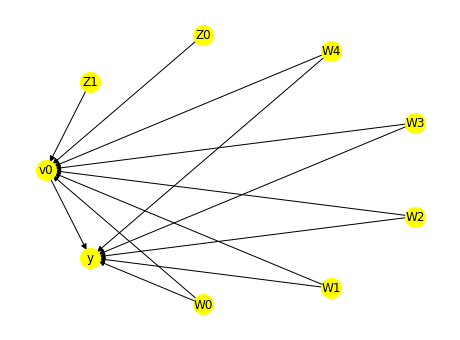

In [9]:
model.view_model(layout='dot')

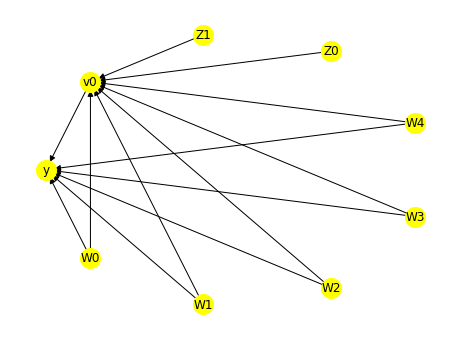

In [10]:
model = CausalModel(
    data=data['df'],
    treatment=data['treatment_name'],
    outcome=data['outcome_name'],
    graph=data['gml_graph'])
model.view_model()

# 2. Identification 

In [11]:
# Identify if the causal inference problem is possible to solve and what are the available methods.
# This does not use any data and only use the graph.

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# The proceed_when_unidentifiable = True is to convey that we are ignoring any unobserved confounding.
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W1,W4,W2,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W2,W3,U) = P(y|v0,W0,W1,W4,W2,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# 3. Estimation

In [12]:
# As we can see three estimation methods are posible.
# We will choose the nonparameteric-average treatment effect.
# There are multiple estimation methods for this from econml library.
# We will use double machine learning (DML)

## 3.1 Double Machine Learning 

We want to estimate the quantity heterogeneous treatment effect (Conditional Average Treatment Effect:CATE);
$$\tau(t_0,t_1,x) = \mathbb{E}[Y(t_1)-Y(t_0)|X=X_0]$$
where $t$ is the treatment, $Y$ is the outcome of interest and $X$ is the observable we condition on. This measures the effect on the output when going from treatment value $t_0$ to $t_1$. 

If treatment is continuous then we define a local effect around treatment point (marginal CATE).
$$\delta\tau(t,x)=\mathbb{E}[\Delta_t{Y}(t)|X=x]$$

Out Data takes the form $\{Y_i(T), T_i, X_i, W_i, Z_i\}$.
$X_i$ and $W_i$ are either called confounder or co-variates or controls. They have an effect on both the treatment and the outcome. We differentiate $X_i$ and call them features because these are the variables we want to measure treatment effect heterogeneity. 

$Z_i$ are instruments. They only affect treatment. 

It is important to note that in this method it is difficult to access the direct counter factual prediction. We only model the difference or the CATE. But methods exist that are extensions of the approach proposed here which are capable of counter factual predictions. 

#### Double Machine Learning method to estimate CATE

Is useful when,
> All confounders are observed and there are too many of them (high dimensional)
> Outcome can not be modeled by a parametric function.

Can be reduced to two predictive tasks:

1. Predicting the outcome from the confounders (Can use any ML model)
2. Predicting the treatment from the confounders (Can use any ML model)

Then combine these two predictive models in the final stage estimation to create a model of the heterogeneous treatment effect. For the final stage estimation we can also use any ML model. 

DML methods perform global fits in contrast to other methods (orthogonal random forests). Local methods try to match target features that are similar and try to learn treatment effect in a localized way. 

### When should we use it.

Suppose you have observational (or experimental from an A/B test) historical data, where some treatment(s)/intervention(s)/action(s)  were chosen and some outcome(s)  were observed and all the variables  that could have potentially gone into the choice of , and simultaneously could have had a direct effect on the outcome  (aka controls or confounders) are also recorder in the dataset.

If your goal is to understand what was the effect of the treatment on the outcome as a function of a set of observable characteristics  of the treated samples, then one can use this method.

Then by simply inspecting for which X the effect was positive, optimal treatment policy can be learned. 

<h5 style="color:Tomato;"> We can use this to answer questions like,
    
1. What type of customers are most likely to not-churn/churn after getting offer emails
2. What type of customers are most likely to not-churn/churn after getting customer support </h5>

### It would be useful to first formalize the policy/treatment questions that we would like to address because the method that we need to use will depend on the questions we want to ask. 



### Formal Methodology for DML
We assume following structural equations hold for the data generating process. 

$$Y=\theta(x).T + g(X,W) + \epsilon \quad \quad \mathbf{E[\epsilon|X,W]}=0$$
$$T = f(X,W) + \eta \quad \quad \quad \quad \quad \mathbf{E[\eta|X,W]=0}$$
$$\mathbf{E}[\eta,\epsilon|X,W]=0$$

Our goal is to estimate marginal CATE $\theta(x)$
Since,
$$\mathbf{E}[Y|X,W]=\theta(X)\,\mathbf{E}[T|X,W]$$
So, $$Y-\mathbf{E}[Y|X,W]=\theta(x).(T-\mathbf{E}[T|X,W])+\epsilon$$

We use machine learning models to model the following two functions. 

$$\textrm{non_parametric_ML_model_1} \quad q(X,W)=\mathbf{E}[Y|X,W]$$
$$\textrm{non_parametric_ML_model_2} \quad f(X,W)=\mathbf{E}[T|X,W]$$

Then we compute the residuals,

$$\hat{Y}=Y-q(X,W)$$
$$\hat{T}=T-f(X,W)=\eta$$

These residuals are related by,

$$\hat{Y}=\theta(X).\hat{T}+\epsilon$$

Since $$\mathbf{E}[\epsilon,\eta|]=0$$, estimating $\theta(X)$ is a regression problem. 

$$\hat{\theta}=\arg \min_{\theta \in \Theta}\mathbf{E}_{\eta}[(\hat{Y}-\theta(X).\hat{T})^2]$$

We can choose different model classes for $\Theta$.
1. It can be a constant or a low dimensional linear function.
2. It can be in a Reproducing kernel hilbert space.
3. It can be an high dimensional sparse linear space.
4. It can be a non-parametric lipchitz function and use random forest models to fit the function.

#### In the following we use DML in Econml. There are many other methods that can be used depending on the problem at hand.
It assumes $\Theta$ to be a linear in $X$. Allows any arbitrary scikit-learn linear estimator to be defined as
the final stage. (ElasticNet, Lasso, LinearRegression).
#### Other methods that might be interest to churn problem.
1. SparseLinearDML (When you have too many features)
2. NonParamDML (Only when treatment is binary)
3. CausalForestDML (When you have too many features)
A more complete list with descriptions are available here https://econml.azurewebsites.net/spec/estimation/dml.html

#### Methods outside of DML
1. Meta-Learners (Discrete treatment CATE only, Combine ML methods in black box manner to get final stage estimate)
2. Doubly Robust Learning
3. Forest Based Estimators

In [13]:
import econml
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand,
                                        method_name='backdoor.econml.dml.DML',
                                        method_params={
                                            'init_params':{'model_y':GradientBoostingRegressor(),
                                                          'model_t':GradientBoostingRegressor(),
                                                          'model_final':LassoCV(fit_intercept=False)},
                                            'fit_params':{}
                                        })
print(dml_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W1,W4,W2,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W2,W3,U) = P(y|v0,W0,W1,W4,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W4+W2+W3 | 
Target units: ate

## Estimate
Mean value: 9.950740315672011
Effect estimates: [9.95074032 9.95074032 9.95074032 ... 9.95074032 9.95074032 9.95074032]



In [14]:
data['df'][data['outcome_name']]

0       11.360257
1      -12.893506
2       19.742538
3       17.540366
4        4.672168
          ...    
9995    13.818644
9996    17.881842
9997    19.573680
9998    -5.057566
9999     3.026822
Name: y, Length: 10000, dtype: float64

In [15]:
# import econml
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LassoCV
# from sklearn.ensemble import GradientBoostingRegressor
# dml_estimate = model.estimate_effect(identified_estimand,
#                                         method_name='backdoor.econml.dml.CausalForestDML',
#                                         method_params={
#                                             'init_params':{'model_y':LassoCV(),
#                                                           'model_t':LassoCV(),
#                                                             'criterion':'het', 
#                                                             'n_estimators':'10000',       
#                                                             'min_samples_leaf':'10', 
#                                                             'max_depth':'None', 
#                                                             'max_samples':'0.5',
#                                                             'discrete_treatment':'False',
#                                                             'honest':'True',
#                                                             'inference':'True',
#                                                             'cv':'10',
#                                                             },
#                                             'fit_params':{},
#                                         })
# print(dml_estimate)

# 4. Refutation


In [16]:
# Check the robustness of the estimate by administrating a test. This check the assumptions baked into the analysis.

## 4.1. Placebo test

In [17]:
# Popular test: Placebo test
# In this test replace the treatement/action variable with random values. Then redo the analysis.
# We should get zero effect if this test is succesful. 

refute_results = model.refute_estimate(identified_estimand, dml_estimate,
                                          method_name='placebo_treatment_refuter')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [18]:
print(refute_results)

Refute: Use a Placebo Treatment
Estimated effect:9.950740315672011
New effect:-0.004578997335752577
p value:0.72



### The test is succesful! we have the new effect to be almost zero! We can trust this causal analysis. 

## 4.2. Random confounder

In [19]:
# Another test is adding a random common cause varaibel
# The treatement effect should not be changed by addition of this random confounder.


In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Add a random common cause
Estimated effect:9.950740315672011
New effect:9.931537416660602
p value:0.25



### With a random confounder added the mean effect does not change by much. So we can say the causal analysis has passed this test too

## 4.3. Add unobserved common cause variable

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

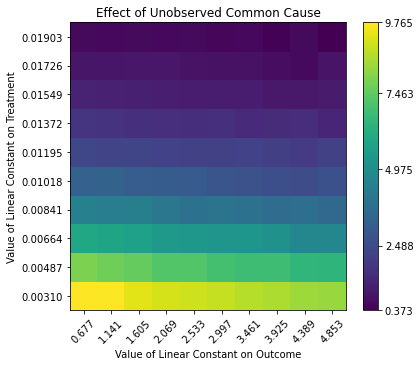

In [21]:
# Add a confounder that can affect both treatement and target in a linear way. 
# We can either control how much is the effect or let dowhy control it so that it is not
# bigger than already existing confounder effects.
res_unobserved_auto = model.refute_estimate(identified_estimand, dml_estimate,
                                           method_name='add_unobserved_common_cause',
                                           confounder_effect_on_treatment='binary_flip',
                                           confounder_effect_on_outcome='linear')

In [22]:
print(res_unobserved_auto)

Refute: Add an Unobserved Common Cause
Estimated effect:9.950740315672011
New effect:(0.37344055962887246, 9.76469506523861)



#### The above test tell us the effect of treatement on the output is positive.

## 4.4. Removing a subset of data


In [23]:
res_subset=model.refute_estimate(identified_estimand,  dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Use a subset of data
Estimated effect:9.950740315672011
New effect:9.943253161904941
p value:0.43999999999999995



# Interperation 

In [24]:
import shap

In [25]:
data['df'][data['common_causes_names']].shape

In [26]:
X = data['df'][data['common_causes_names']]
Y = data['df'][data['outcome_name']]
T = data['df'][data['treatment_name']]

In [27]:
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV

# set parameters for causal forest 
causal_forest = CausalForestDML(criterion='het', 
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=None)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

100%|===================| 9978/10000 [02:41<00:00]        

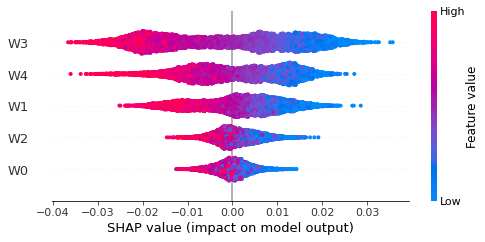

In [28]:
import shap
from econml.dml import CausalForestDML

# fit causal forest with default parameters 
causal_forest = CausalForestDML()
causal_forest.fit(Y, T, X=X, W=None)

# calculate shap values of causal forest model 
shap_values = causal_forest.shap_values(X)
# plot shap values 
shap.summary_plot(shap_values['y']['v0'])

#### Challenges
1. I could not get CausalForestDML to work through do-why. I suspect there might be other integration issues for 
    methods in econml
2. I could not get shap values for the do-why estimators to work. 
